In [94]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [95]:
class MAB(ABC):
    
    @abstractmethod
    def play(self, tround):
        # Current round of t (for my implementations average mean reward array 
        # at round t is passed to this function instead of tround itself)
        self.tround = tround
        # choose an arm which yields maximum value of average mean reward, tie breaking randomly
        chosen_arm = np.random.choice(np.where(self.tround==max(self.tround))[0])
        return chosen_arm
        pass
        
    
    @abstractmethod
    def update(self, arm, reward):
        # get the chosen arm
        self.arm = arm
        # update the overall step of the model
        self.step_n += 1
        # update the step of individual arms
        self.step_arm[self.arm] += 1
        # update average mean reward of each arm
        self.AM_reward[self.arm] = ((self.step_arm[self.arm] - 1) / float(self.step_arm[self.arm]) 
        * self.AM_reward[self.arm] + (1 / float(self.step_arm[self.arm])) * reward)
        return
        pass

In [96]:
class UCB(MAB):
    
    def __init__(self, narms, rho, Q0=np.inf):
        # Set number of arms
        self.narms = narms
        # Rho
        self.rho = rho
        # Q0 values
        self.Q0 = np.ones(self.narms)*np.inf
        # Total step count
        self.step_n = 0
        # Step count for each arm
        self.step_arm = np.zeros(self.narms)
        # Mean reward for each arm
        self.AM_reward = np.zeros(self.narms)
        super().__init__()
        return

    # Play one round and return the action (chosen arm)
    def play(self, tround):
        # Q0 values are initially set to np.inf. Hence, choose an arm with maximum Q0 value (
        # for all of them is np.inf, and therefore will play all of the arms at least one time)  
        if len(np.where(self.Q0==0)[0])<10:
            # choose an arm with maximum Q0 value
            action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
            # after the arm is chosen, set the corresponding Q0 value to zero
            self.Q0[action]=0
            return action + 1
        else:
            # Now, after that we ensure that there is no np.inf in Q0 values and all of them are set to zero
            # we return to play based on average mean rewards
            
            # construct UCB values which performs the sqrt part
            ucb_values = np.zeros(self.narms)
            for arm in range(self.narms):
                if self.step_arm[arm]>0:
                    ucb_values[arm]= np.sqrt(self.rho *(np.log(self.step_n)) / self.step_arm[arm])
            action = super(UCB, self).play(self.AM_reward + ucb_values)

        return action + 1
        
        
    def update(self, arm, reward):
        super(UCB, self).update(arm, reward)
        return

In [97]:

def offlineEvaluate(mab, arms, rewards, right_label, nrounds=None):
    # array to contain chosen arms in offline mode
    chosen_arms = np.zeros(nrounds)
    # rewards of each chosen arm
    reward_arms = np.zeros(nrounds)
    # cumulative reward at each iteration
    cumulative_reward = np.zeros(nrounds)
    
    predict_reward = np.zeros(nrounds)
    # initialize tround to zero
    T = 0
    # initialize overall cumulative reward to zero
    G = 0
    # History or memory of offline evaluator
    history = []
 
    # play once and get the initial action
    #action = mab.play(T)
    right_count = 0
    accurary_history = []
    for n in range(nrounds):
        action = mab.play(n)
        if right_label == action:
            right_count = right_count + 1
        for i in range(10):
            # update parameters and play only when chosen arm from bandit matches data
            if action == arms[i]:


                seed = np.random.randint(0,100, size=1)
                # get the reward of chosen arm at round T
                predict_reward[T] = mab.AM_reward[i]
                reward_arms[T] = rewards[i][seed]

                mab.update(action-1, rewards[i][seed])  
                # update overall cumulative reward
                G += rewards[i][seed]
                # update cumulative reward of round T 
                cumulative_reward[T] = G
                # store chosen arm at round T
                chosen_arms[T] = action
                T +=1
            else:
                # if desired tround ends, terminate the loop
                continue
        accurary = right_count / (n+1)
        accurary_history.append(accurary)
    return reward_arms, chosen_arms, cumulative_reward, predict_reward, accurary_history

In [98]:
def setThreshold(p):
    a = np.random.normal(0, 1, 100000)
    x0 = np.random.rand(10)
    ratio = p*10/sum(x0)
    x1 = x0*ratio
    while np.max(x1) > 100:
        x0 = np.random.rand(10)
        ratio = p*10/sum(x0)
        x1 = x0*ratio
    l_x = [np.percentile(a,x1[i]) for i in range(10)]
    print(l_x)
    return [np.random.normal(np.percentile(a, x1[i]), 1, 10000) for i in range(10)], x1

In [99]:
# load dataset and initialize arms, rewards and contexts arrays
#data = np.loadtxt('./dataset.txt')
arms = [1,2,3,4,5,6,7,8,9,10]

rewards, plist = setThreshold(90)
plist

[2.1751185702459255, 1.1114719487283227, 1.9062797666357043, 1.2488576796583866, 1.7644626035247015, 1.2180258520554714, 0.5284437585166616, 1.0050498533017167, 1.325434998880067, 2.5031445292937047]


array([98.45195715, 86.49975179, 97.13860583, 89.23776186, 96.03470178,
       88.65927437, 69.95514805, 84.11300342, 90.55056739, 99.35922836])

In [100]:
right_label = np.argmax(plist) + 1
right_label

10

In [101]:
mab = UCB(10, 1.0)
results_UCB, chosen_arms_UCB, cumulative_reward_UCB, rewards_UCB, accurary_history = offlineEvaluate(mab, arms, rewards, right_label, 100000)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 2.444846921577761


In [102]:
chosen_arms_UCB

array([ 4.,  5.,  8., ..., 10., 10., 10.])

In [103]:
np.where(chosen_arms_UCB==3)

(array([    4,    46,    73,   241,   242,   243,   336,   337,   338,
          545,   546,  4545, 16258, 16259, 16260, 16261, 18137, 19967,
        37101, 37102, 53414, 53415, 53416, 53417, 53418], dtype=int64),)

In [104]:
np.where(chosen_arms_UCB==2)

(array([    3,    11,    14,    19,    24,    25,    29,    41,    42,
          125,   319,   497,   935,  1303,  1927,  1928,  7611,  7612,
        46881, 51156, 74495, 94210, 94211, 94212, 94213], dtype=int64),)

In [105]:
np.where(chosen_arms_UCB==1)

(array([    5,    12,    13,    16,    17,    18,    21,    22,    23,
           26,    27,    28,    30,    31,    32,    43,    44,    68,
           69,    70,    71,    72,    98,   100,   139,   208,   209,
          251,   502,   503,   655,   656,   936,   937,   938,   939,
          940,   941,   942,   943,   944,   945,   946,   947,   948,
          949,   950,   951,   952,   953,   954,   955,   956,   957,
          958,   959,   960,   961,   962,   963,   964,   965,   966,
          967,   968,   969,   970,   971,   972,   973,   974,   975,
          976,   977,   978,   979,   980,   981,   982,   983,   984,
          985,   986,   987,   988,   989,   990,   991,   992,   993,
          994,   995,   996,   997,   998,   999,  1000,  1001,  1002,
         1003,  1004,  1005,  1006,  1007,  1008,  1009,  1010,  1011,
         1012,  1013,  1014,  1015,  1016,  1017,  1018,  1019,  1020,
         1021,  1022,  1023,  1024,  1025,  1026,  1027,  1028,  1029,
      

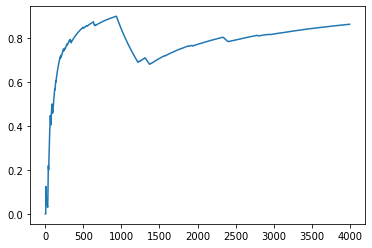

In [106]:
plt.plot(accurary_history[:4000])

In [107]:
results_UCB

array([ 0.72519414,  2.92348998, -0.37643633, ...,  1.82207881,
        4.28909772,  1.72903877])

In [108]:
len(np.where(rewards_UCB > 0)[0])

99988

In [109]:
len(np.where(results_UCB > 0)[0])

99971

In [110]:
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# x = np.linspace(0,3,10000)
# plt.title('Predict and Acutual Reward Comparision')
# plt.plot(x_axix, reward_UCB, color='green', label='Predict')
# plt.plot(sub_axix, results_UCB, color='red', label='Actual')
# plt.legend() # 显示图例

# plt.xlabel('times')
# plt.ylabel('reward')
# plt.show()

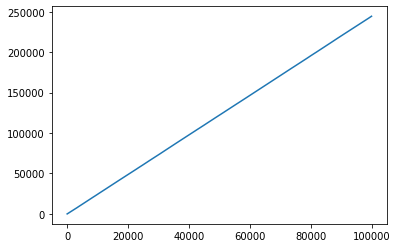

In [111]:
plt.plot(cumulative_reward_UCB)

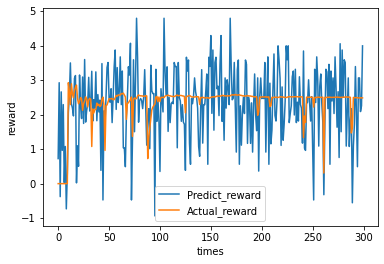

In [112]:
plt.plot(results_UCB[:300])
plt.plot(rewards_UCB[:300])
plt.xlabel('times')
plt.ylabel('reward')
plt.legend(["Predict_reward","Actual_reward"])
plt.show()

In [113]:
results_UCB

array([ 0.72519414,  2.92348998, -0.37643633, ...,  1.82207881,
        4.28909772,  1.72903877])

In [114]:
chosen_arms_UCB

array([ 4.,  5.,  8., ..., 10., 10., 10.])

In [115]:
cumulative_reward_UCB

array([7.25194142e-01, 3.64868412e+00, 3.27224779e+00, ...,
       2.44478674e+05, 2.44482963e+05, 2.44484692e+05])

In [116]:
# 每一个臂的预测reward
mab.AM_reward

array([ 2.30933636,  1.73079386,  1.70755882,  1.33056292,  1.8220015 ,
        1.63760256, -0.0067784 ,  0.46440352,  0.48339856,  2.44660621])

In [117]:
0.14690929894690857
0.9245774220883364
1.9411605758761852
2.9399821995064235
3.960375551463821
4.987506878175843
6.026052641348151
6.807000230507154
7.870264325826362
9.150845459409592

9.150845459409592